In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

from IPython.display import display, Math

import inspect
import pandas as pd
import autograd.numpy as np
import matplotlib.pyplot as plt

from utils.data_gen import sample_gaussian_mixture, generate_regression_outputs
from utils.models import BNN, BNN_LV, BayesianModel, SamplerModel


In [2]:
# Show Bayesian model:
print(inspect.getsource(BayesianModel))


class BayesianModel:

    """
    A Bayesian model for BNN LV.
    """
    
    def __init__(
        self,
        X, Y, nn,
        prior_weights_mean = 0.0,
        prior_weights_stdev = 1.0,
        prior_latents_mean = 0.0,
        prior_latents_stdev = 1.0,
        likelihood_stdev = 1.0,
        output_noise_stdev = 1.0,
        label = '',
    ):
        
        # Check inputs:
        assert len(X.shape)==2, f"Expects X to be N by M, not {X.shape}"
        assert len(Y.shape)==2, f"Expects Y to be N by K, not {Y.shape}"
        assert X.shape[0]==Y.shape[0], f"Expects X {X.shape} and Y {Y.shape} to have same first dimension."
        
        # Get dimensions:
        self.L = 1
        self.N = X.shape[0]
        self.M = X.shape[1]
        self.K = Y.shape[1]
        self.D = nn.D
        
        # Store parameters:
        self.X = X
        self.Y = Y
        self.nn = nn
        self.prior_weights_mean = prior_weights_mean
        self.prior_weights_stdev = prior_weight

In [3]:
# Data Loading
Y_train, X_train = generate_regression_outputs(type='hsc')
X_test = np.linspace(-6,6, 100)


In [4]:
# Define Bayesian Neural Network with Latent Variable (BNN_LV):
L = 1
N, M = X_train.shape  # Input shape.
_, K = Y_train.shape  # Output shape.
gamma = 1.0  # Standard deviation of noise for each latent input.
sigma = 1.0  # Standard evation of noise on each model output.

# Newtork architecture:
architecture = {
    'input_n' : M,  # 1 output.
    'output_n' : K,  # 1 input.
    'hidden_layers' : [3,3],
    'biases' : [1,1,1],
    'activations' : ['relu', 'relu', 'linear'],
    'gamma' : gamma,
    'sigma' : sigma,
    'seed' : 207,
}

# Initialize network:
bnn_lv = BNN_LV(architecture=architecture)

# Get number of weights in network:
D = bnn_lv.D

# Train network from random restarts:
S = 250
W_samples = []
for _ in range(S):
    bnn_lv.weights = bnn_lv.random_weights()
    bnn_lv.fit(X_train, Y_train, step_size=0.01, max_iteration=50, check_point=None, regularization_coef=None)
    W_samples.append( bnn_lv.weights )
W_samples = np.vstack(W_samples)

W_samples.shape


(250, 25)

In [5]:
# Define Bayesian model (with a posterior on W and Z):
bayesian_model = BayesianModel(
    X = X_train,
    Y = Y_train,
    nn = bnn_lv,
    prior_weights_mean = 0,
    prior_weights_stdev = 1.0,
    prior_latents_mean = 0,
    prior_latents_stdev = gamma,
    likelihood_stdev = 1.0,
    output_noise_stdev = sigma,
    label = 'Toy example with heteroskedastic noise',
)
# Wrap the model so that it takes a single input (`samples`) that stores both W and Z:
sampler_model = SamplerModel(bayesian_model)

sampler_model.display()

sampler_model.info()


<IPython.core.display.Math object>

{'L': 1, 'N': 750, 'M': 1, 'K': 1, 'D': 25}

(250, 775)  -->  S by D+N*L


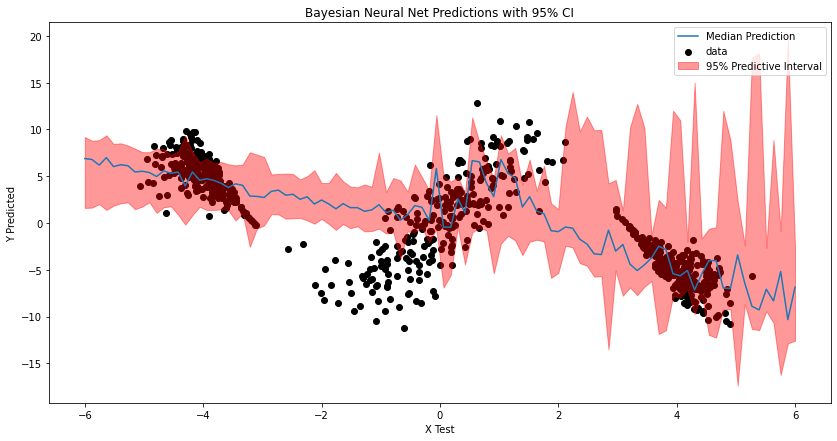

In [6]:
# Generate random weights (for demo purposes):
# W_samples = bnn_lv.random_weights(S)  # Create above with BNN_LV.
Z_samples = bnn_lv.random.normal(loc=0, scale=gamma, size=(S,N,L))
samples = sampler_model.stack(W_samples, Z_samples)
print(samples.shape, " -->  S by D+N*L")

# Get training data and define test values:
x_test = np.linspace(-6, 6, 100)
x_train = sampler_model.X.flatten()
y_train = sampler_model.Y.flatten()
Y_pred = sampler_model.predict(X=x_test.reshape(-1,1), samples=samples).reshape(S,-1)

# Calculate percentiles
y_lower = np.percentile(Y_pred, q=2.5, axis=0)
y_upper = np.percentile(Y_pred, q=97.5, axis=0)
y_med = np.percentile(Y_pred, q=50, axis=0)

# Plot with confidence
plt.figure(figsize=(14,7))
plt.scatter(x_train, y_train, color='black', label='data')
plt.plot(x_test, y_med, label="Median Prediction")
plt.fill_between(x_test, y_lower, y_upper, alpha=0.4, color='r', label="95% Predictive Interval")
plt.title("Bayesian Neural Net Predictions with 95% CI")
plt.xlabel("X Test")
plt.ylabel("Y Predicted")
plt.legend()
plt.show()
